In [44]:
import cv2
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt

from math import degrees, radians
from skimage.draw import line_nd
from skimage.color import gray2rgb, rgb2gray

import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

Funkcje pomocnicze

In [45]:
def add_padding(image, color=(0, 0, 0)):
    padding = int(image.shape[0]/2)
    padded_image = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=color)
    return padded_image

def center_of(array):
    """Center indices of an n-dimensional array"""
    return np.floor(np.array([array.shape[0], array.shape[1]]) / 2).astype(int)

def rescale(array, min=0, max=1):
    """Rescale array elements to range [min, max]"""
    res = array.astype('float32')
    res -= np.min(res)
    res /= np.max(res)
    res -= min
    res *= max
    return res

Wczytanie obrazu

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0 

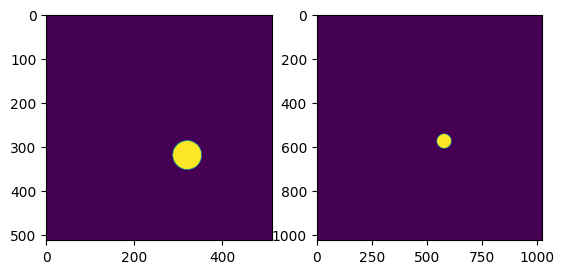

In [50]:
def choose_file():
    root = tk.Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    filename = filedialog.askopenfilename(initialdir=".", title="Wybierz obraz", filetypes=(("jpeg files", ".jpg"), ("all files", ".")))
    %gui tk
    # root.destroy()
    return filename

filename = choose_file()
# filename = "tomograf-obrazy/kolo.jpg"
img = cv2.imread(filename, 0)
img = cv2.resize(img, (512,512))
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
# Change coloring from BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
print(img)
padded_img = add_padding(img)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img)
ax2.imshow(padded_img)


In [36]:
def emitter_coords(alpha, radius=1):
    x = radius * np.cos(radians(alpha)) + radius - 2
    y = radius * np.sin(radians(alpha)) + radius - 2
    
    return (x, y)
    
def detectors_coords(alpha, angle_range, count, radius=1):
    coords = []
    for n in range(count):
        x = radius * np.cos(radians((alpha + 90 - angle_range/2) + (n * angle_range/(count-1)))) + radius -1
        y = radius * np.sin(radians(alpha + 90 - angle_range/2 + (n * angle_range/(count-1)))) + radius -1
        
        coords.append((x, y))
    return np.floor(coords).astype(int)

In [11]:
def bresenham(x0, y0, x1, y1):
    if abs(y1 - y0) > abs(x1 - x0):
        swapped = True
        x0, y0, x1, y1 = y0, x0, y1, x1
    else:
        swapped = False
    m = (y1 - y0) / (x1 - x0) if x1 - x0 != 0 else 1
    q = y0 - m * x0
    if x0 < x1:
        xs = np.arange(np.floor(x0), np.ceil(x1) + 1, +1, dtype=int)
    else:
        xs = np.arange(np.ceil(x0), np.floor(x1) - 1, -1, dtype=int)
    ys = np.round(m * xs + q).astype(int)
    if swapped:
        xs, ys = ys, xs
    return np.array([xs, ys])

def radon_lines(emitter, detectors):
    return [bresenham(emitter[0], emitter[1], x1, y1) for (x1, y1) in detectors]

In [41]:
def single_radon_transform(detector_count, angle_range, image, radius, alpha):
    emitter = emitter_coords(alpha, radius)
    detectors = detectors_coords(alpha, angle_range, detector_count, radius)
    lines = radon_lines(emitter, detectors)
    # result = rescale(np.array([np.sum(image[tuple(line)]) for line in lines]))
    result = np.array([np.sum(image[tuple(line)]) for line in lines])
    return result

def radon_transform(image, scan_count, detector_count, angle_range):
    # center = center_of(image)
    # print("center: ", center)
    width = image.shape[0]
    print("width: ", width)
    radius = width // 2
    alphas = np.linspace(0, 180, scan_count)
    
    sinogram = np.zeros((scan_count, detector_count))
    results = []
    for i, alpha in enumerate(alphas):
        # result = single_radon_transform(detector_count, angle_range, image, radius, alpha) TODO
        emitter = emitter_coords(alpha, radius)
        detectors = detectors_coords(alpha, angle_range, detector_count, radius)
        for j, sensor_pos in enumerate(detectors):
            line_sum = 0
            print(line_sum)
            rows, cols = line_nd(emitter, sensor_pos)
            for x, y in zip(rows, cols):
                line_sum += image[x-1][y-1]
            print(line_sum)
            sinogram[i][j] = line_sum / len(rows)
        # results.append(result)
        
    return sinogram

In [27]:
def calculate_position(r, angle, offset=0):
    angle_rad = np.radians(angle + offset)
    return int(r * np.cos(angle_rad) + r), int(r * np.sin(angle_rad) + r)

def sinogram(image, r, l, alpha, detectors, apply_filter):
    num_emitters = int(360 / alpha)
    sinogram = np.zeros((num_emitters, detectors))

    for i in range(num_emitters):
        angle = alpha * i
        emiter_pos = calculate_position(r, angle)
        sensor_positions = [calculate_position(r, angle, np.degrees(np.pi - np.radians(l) / 2 + j * (np.radians(l) / (detectors - 1)))) for j in range(detectors)]
        
        for j, sensor_pos in enumerate(sensor_positions):
            line_sum = 0
            rows,cols = line_nd(emiter_pos, sensor_pos)
            for x,y in zip(rows,cols):
                line_sum += image[x-1][y-1]
            sinogram[i][j] = line_sum / len(rows)
    
    # if apply_filter:
    #     for i in range(len(sinogram)):
    #         sinogram[i] = np.convolve(sinogram[i], create_filter(), mode='same')

    return sinogram

In [42]:
number_of_scans = 360
number_of_detectors = padded_img.shape[0]
angle_range = 270
sinogram = radon_transform(padded_img, number_of_scans, number_of_detectors, angle_range)
plt.imshow(sinogram, cmap='gray')

width:  1024
0
[0 0 0]


ValueError: setting an array element with a sequence.